After implementing deep learning algorithm (only fully-connected layers introduced) and data augmentation, now let's try whether CNN could give us better output or not.

LeNet-5 Structure

    input: 28 * 28 images
    zeropadding: (2, 2) => 32 * 32
    conv_1: 5 * 5 and 6 filters => 28 * 28 * 6
    act_1: activation
    avgpool_2: 2 * 2 and non-overlapping => 14 * 14 * 6
    conv_3: 5 * 5 and 16 filters => 10 * 10 * 16
    act_2: activation
    avgpool_4: 2 * 2 and non-overlapping => 5 * 5 * 16
    conv_5: 5 * 5 and 120 filters => fully-connected 120 * 1
    act_3: activation
    fc_6: fully-connected 84 * 1
    act_4: activation
    output_layer(act_4): 10 * 1

Note: not implementing bias in conv

In [1]:
import warnings
warnings.filterwarnings('ignore')

#import necessary modules
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dropout, Dense, Activation, Flatten, BatchNormalization
from keras.models import Sequential

#can apply to_categorical as pd.get_dummies
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#import other necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [43]:
#load datasets
#read training and test sets
data = np.loadtxt('data/train.csv', delimiter = ',', skiprows = 1)
test = np.loadtxt('data/test.csv', delimiter = ',', skiprows = 1)

In [4]:
data.shape, test.shape

((42000, 785), (28000, 784))

In [5]:
#set features and labels (arrays)
X_train = data[:, 1:].reshape((-1,28,28,1)).astype(float)
Y_train = data[:, 0].reshape((-1,1))
X_test = test.reshape((-1,28,28,1)).astype(float)

(<matplotlib.image.AxesImage at 0x13c3c6e48>, array([1.]))

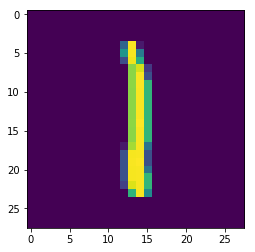

In [6]:
#check data
plt.imshow(X_train[1000].reshape((28,28))), Y_train[1000]

In [7]:
#train test split
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train,
                                                   Y_train,
                                                   test_size = 0.025,
                                                   random_state = 1024,
                                                   stratify = Y_train)

In [8]:
Y_train.shape, Y_dev.shape, X_train.shape, X_dev.shape, X_test.shape

((40950, 1),
 (1050, 1),
 (40950, 28, 28, 1),
 (1050, 28, 28, 1),
 (28000, 28, 28, 1))

In [9]:
#Normalization
X_train /= 255.
X_dev /= 255.
X_test /= 255.
Y_train = np_utils.to_categorical(Y_train, 10)
Y_dev = np_utils.to_categorical(Y_dev, 10)

(<matplotlib.image.AxesImage at 0x13b5da710>,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

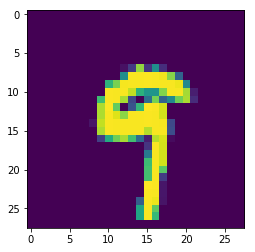

In [10]:
plt.imshow(X_train[10].reshape((28,28))), Y_train[10]

In [11]:
Y_train.shape, X_train.shape

((40950, 10), (40950, 28, 28, 1))

In [12]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    
    return X_pad

In [13]:
X_train = zero_pad(X_train, 2)
X_dev = zero_pad(X_dev, 2)
X_test = zero_pad(X_test, 2)

(<matplotlib.image.AxesImage at 0x13b382908>,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

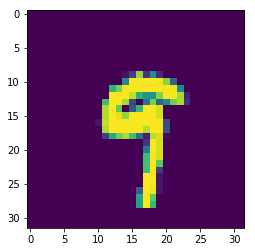

In [14]:
plt.imshow(X_train[10].reshape((32,32))), Y_train[10]

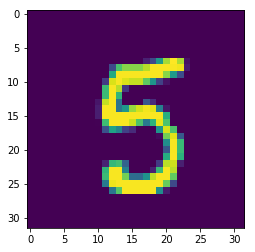

In [15]:
plt.imshow(X_test[10].reshape((32,32)))

In [16]:
Y_train.shape, Y_dev.shape, X_train.shape, X_dev.shape, X_test.shape

((40950, 10),
 (1050, 10),
 (40950, 32, 32, 1),
 (1050, 32, 32, 1),
 (28000, 32, 32, 1))

In [17]:
def cnn_model_builder(input_shapes):
    #create model
    model = Sequential()
    #layer1-1: ZeroPadding2D
    #model.add(ZeroPadding2D(padding = (2,2), input_shape=input_shape))
    #add before put input into the model
    #layer1-2: first Conv2D with relu
    model.add(Conv2D(6, kernel_size = (5,5), activation='relu', input_shape = input_shapes))
    #apply BatchNormalization before applying MaxPooling
    model.add(BatchNormalization())
    
    #layer2: MaxPooling2D
    model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
    
    #layer3-1: second Conv2D with relu
    model.add(Conv2D(16, kernel_size = (5,5), activation='relu'))
    #apply BatchNormalization before applying second Conv2D
    model.add(BatchNormalization())
    
    #layer4: MaxPooling2D
    model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
    
    #layer5: third Conv2D with relu
    model.add(Conv2D(120, kernel_size = (5,5), activation = 'relu'))
    #apply BatchNormalization before applying Dense layer
    model.add(BatchNormalization())
    #flatten layer
    model.add(Flatten())
    #layer6: fully-connected
    model.add(Dense(84, activation = 'relu'))
    #BatchNorm
    model.add(BatchNormalization())
    #output_layer
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [46]:
input_shapes = (32,32,1)
cnn_model = cnn_model_builder(input_shapes)

In [47]:
cnn_model.compile(loss="categorical_crossentropy",
              optimizer= keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

#weird, why choose adam as optimizer would return a pretty bad dev accuracy?

In [48]:
#learning rate decay setting
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [22]:
cnn_model.fit(X_train, Y_train,
              batch_size=64,
              epochs=5,
              callbacks=[annealer])

Epoch 1/5
40950/40950 [==============================] - 37s 912us/step - loss: 0.1633 - acc: 0.9505
Epoch 2/5
40950/40950 [==============================] - 34s 834us/step - loss: 0.0565 - acc: 0.9821
Epoch 3/5
40950/40950 [==============================] - 32s 790us/step - loss: 0.0385 - acc: 0.9877
Epoch 4/5
40950/40950 [==============================] - 33s 816us/step - loss: 0.0285 - acc: 0.9905
Epoch 5/5
40950/40950 [==============================] - 36s 872us/step - loss: 0.0228 - acc: 0.9926


In [23]:
print(cnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 120)         48120     
__________

In [24]:
### START CODE HERE ### (1 line)
preds = cnn_model.evaluate(x = X_dev, y = Y_dev)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1050/1050 [==============================] - 0s 433us/step

Loss = 0.04209495647322564
Test Accuracy = 0.9895238088426136


In [25]:
Y_dev[501], cnn_model.predict(X_dev)[501].argmax()

(array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 4)

In [26]:
Y_test = np.zeros((X_test.shape[0], 10))
Y_test = cnn_model.predict(X_test)

In [27]:
pred = np.argmax(Y_test, axis = 1)

In [35]:
pred[1001], Y_test[1001].argmax()

(7, 7)

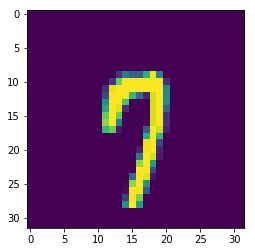

In [36]:
plt.imshow(X_test[1001].reshape((32,32)))

In [38]:
#output to submit file
submissions = pd.DataFrame({'ImageId': np.arange(1 , 1 + test.shape[0]), 'Label': pred.astype(int)})
submissions.to_csv('./keras.csv', index=False)
#0.98714

In [44]:
#read new data
new_data = np.loadtxt('data/new_image_data.csv', delimiter = ',', skiprows = 1)
#print(new_data.shape)
data = np.concatenate((data, new_data), axis=0)

#split features and labels
X_train = data[:, 1:].reshape((-1,28,28,1)).astype(float)
Y_train = data[:, 0].reshape((-1,1))

#norm
X_train /= 255.
#zero padding
X_train = zero_pad(X_train, 2)
#to_categorical
Y_train = np_utils.to_categorical(Y_train, 10)
X_train.shape, Y_train.shape

(19999, 785)


((61999, 32, 32, 1), (61999, 10))

In [49]:
#reset cnn_model
cnn_model = cnn_model_builder(input_shapes)
cnn_model.compile(loss="categorical_crossentropy",
              optimizer= keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [50]:
cnn_model.fit(X_train, Y_train,
              batch_size=64,
              epochs=5,
              callbacks=[annealer])

Epoch 1/5
61999/61999 [==============================] - 60s 975us/step - loss: 0.1404 - acc: 0.9578
Epoch 2/5
61999/61999 [==============================] - 60s 971us/step - loss: 0.0493 - acc: 0.9846
Epoch 3/5
61999/61999 [==============================] - 59s 944us/step - loss: 0.0343 - acc: 0.9884
Epoch 4/5
61999/61999 [==============================] - 60s 971us/step - loss: 0.0246 - acc: 0.9924
Epoch 5/5
61999/61999 [==============================] - 68s 1ms/step - loss: 0.0180 - acc: 0.9947


In [55]:
check_data = cnn_model.predict(X_train)
check_data = np.argmax(check_data, axis = 1)
unmatched = []
for i in range(len(check_data)):
    if check_data[i] != Y_train[i].argmax():
        unmatched.append(i)

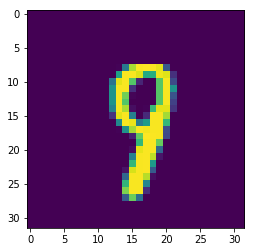

9 8


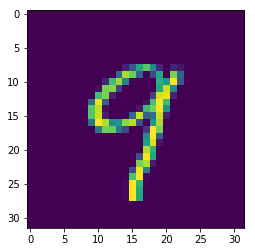

9 4


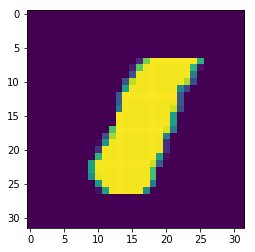

1 6


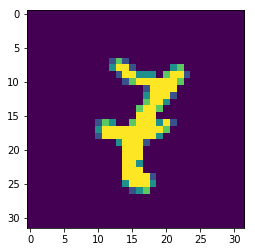

7 8


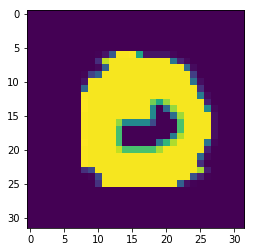

0 8


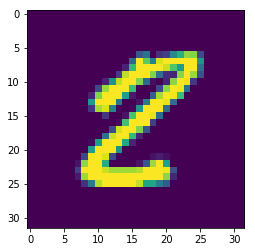

2 8


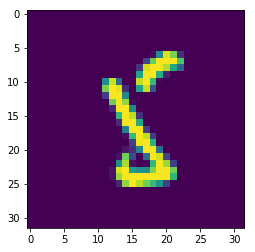

5 8


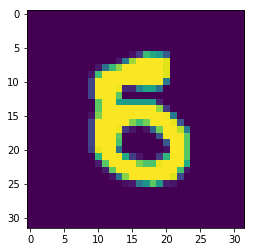

5 6


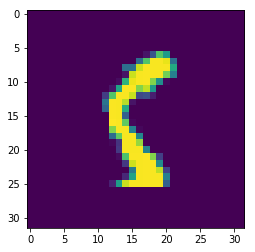

5 8


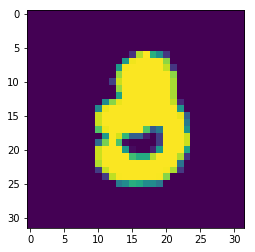

3 8


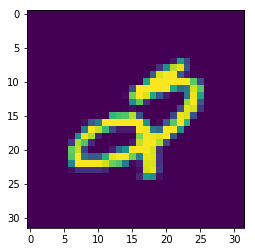

2 8


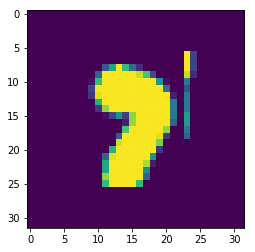

7 8


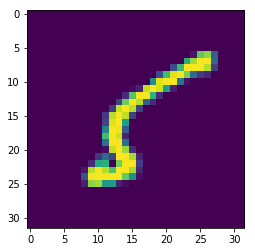

5 6


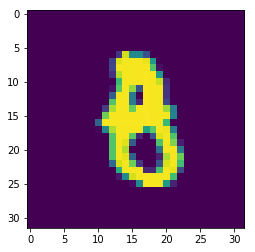

8 6


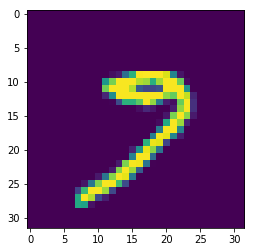

9 7


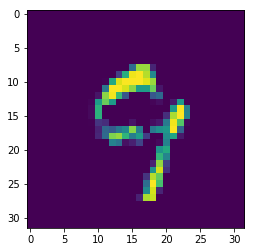

9 7


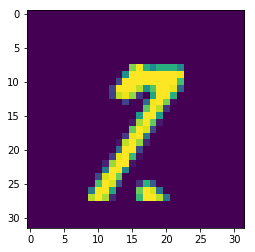

7 2


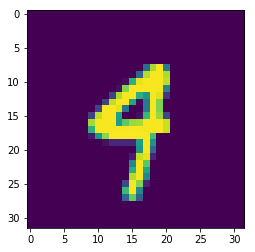

9 4


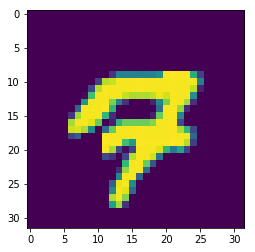

7 8


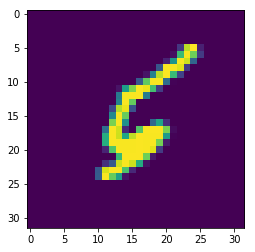

5 6


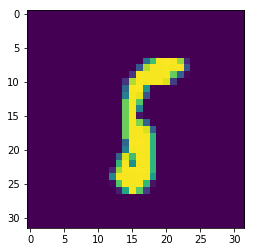

5 8


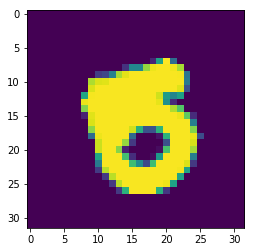

5 6


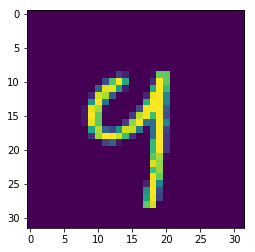

9 4


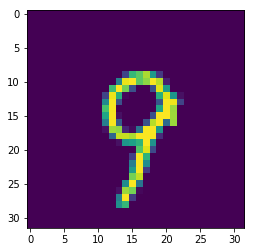

9 8


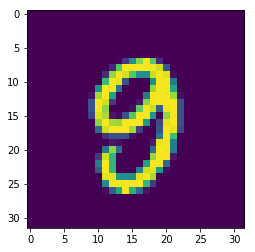

9 8


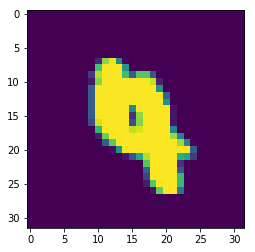

4 9


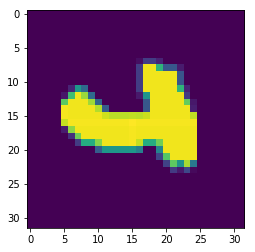

4 2


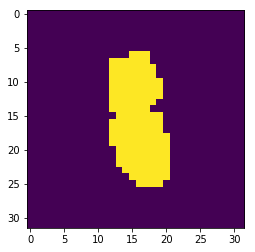

1 8


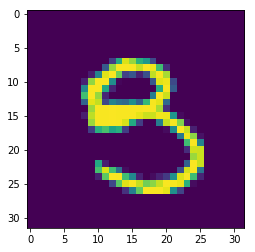

3 8


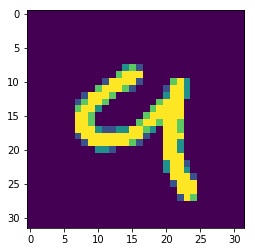

9 4


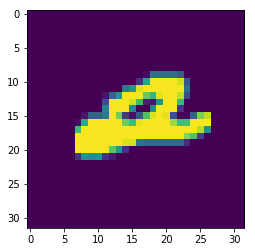

2 0


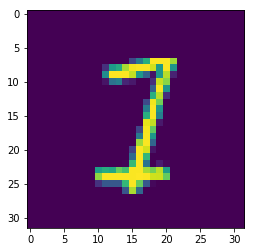

7 1


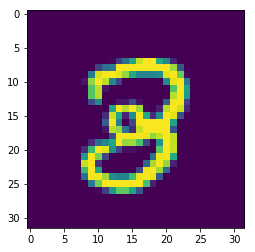

3 8


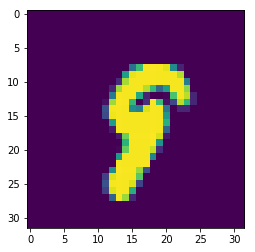

9 8


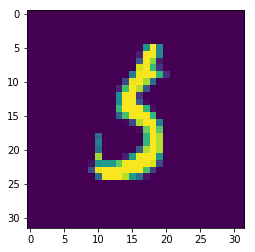

5 3


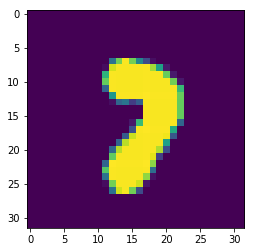

7 8


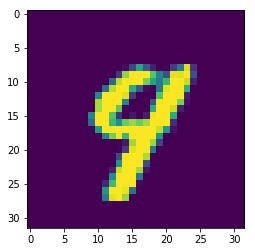

9 4


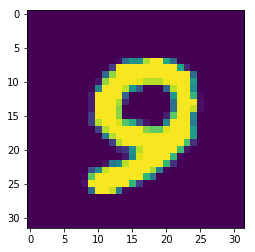

9 8


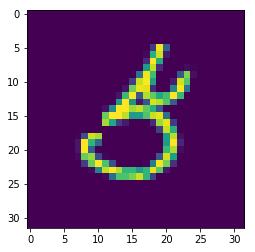

5 8


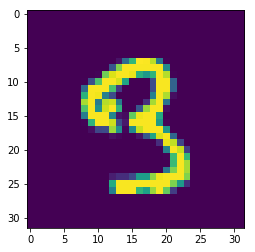

3 8


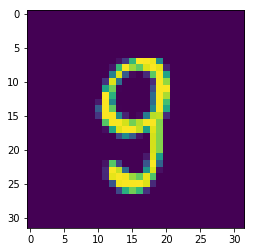

9 8


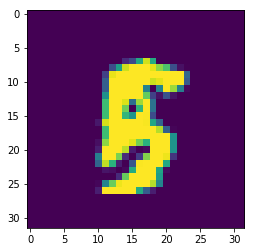

5 8


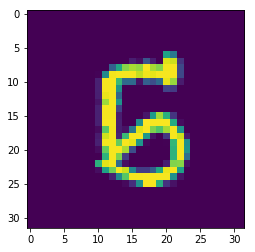

5 6


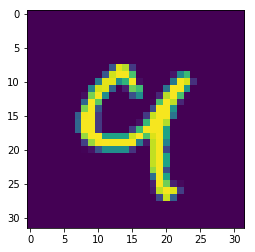

9 4


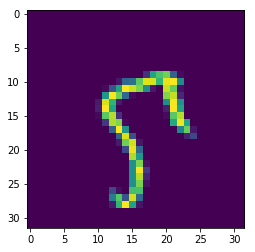

5 8


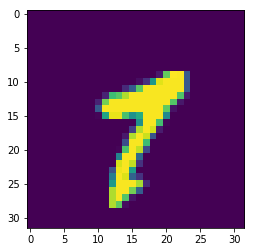

7 8


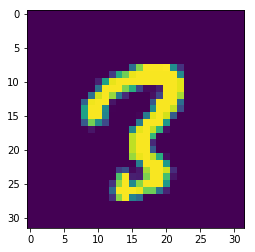

3 8


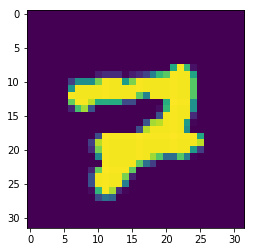

7 2


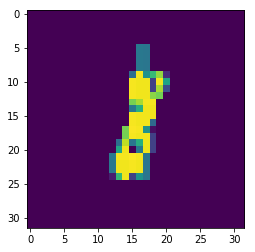

1 8


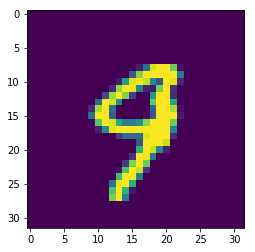

9 4


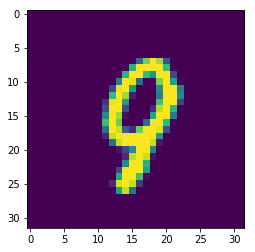

9 8


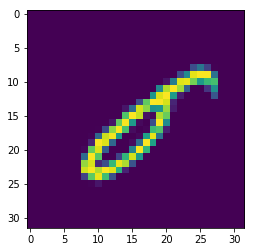

0 8


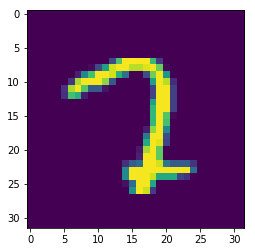

7 2


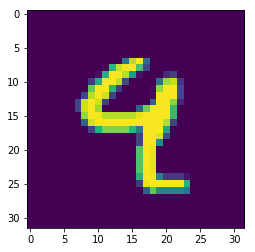

9 4


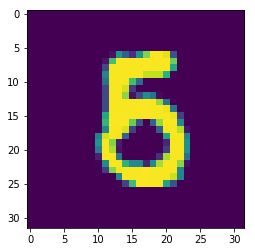

5 6


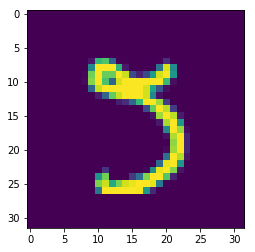

5 3


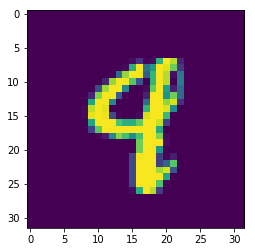

9 8


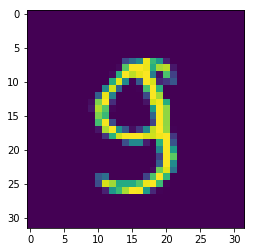

9 8


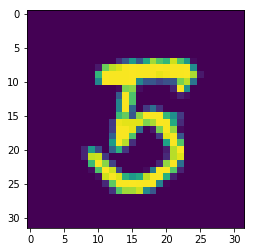

5 3


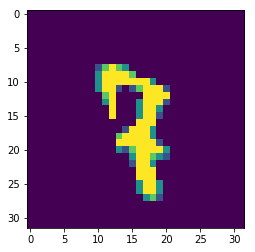

7 8


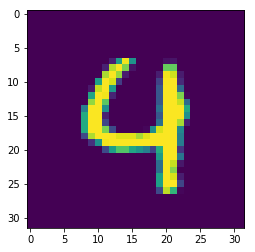

9 4


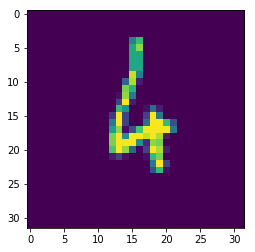

6 4


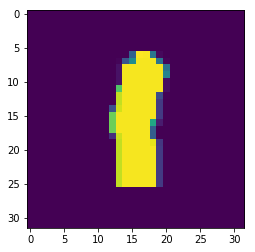

1 6


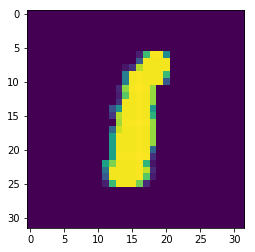

1 6


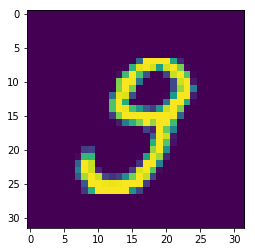

9 8


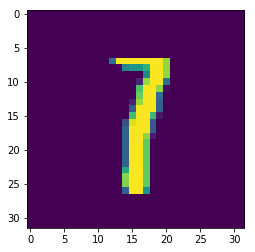

7 1


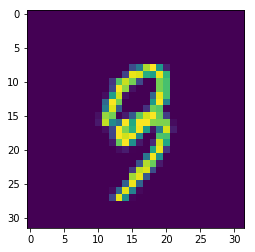

3 8


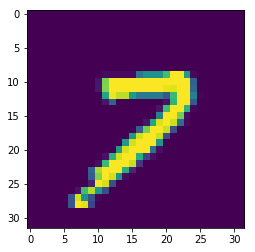

4 7


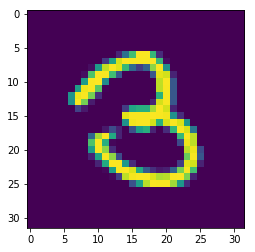

3 8


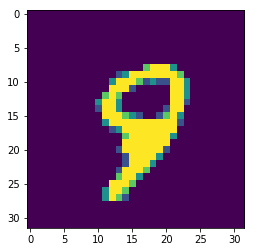

9 8


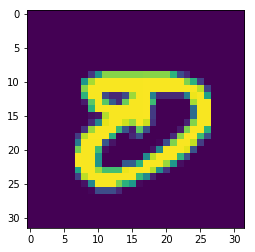

0 8


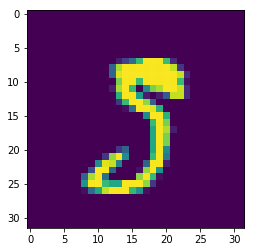

5 8


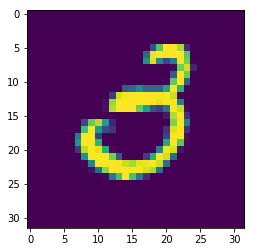

3 5


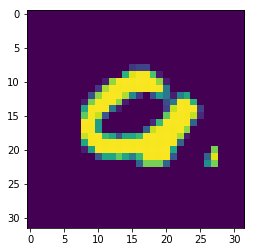

9 6


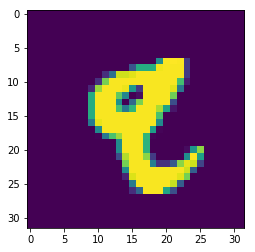

9 8


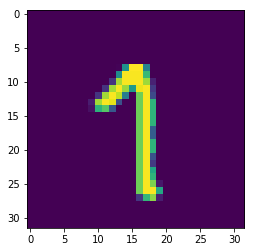

7 1


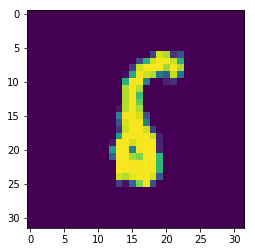

5 6


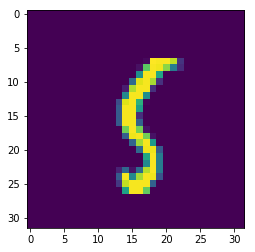

5 8


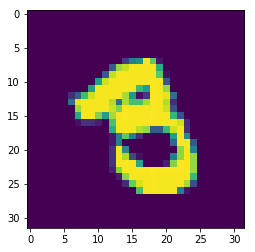

3 8


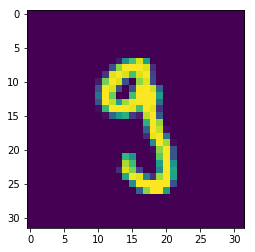

9 8


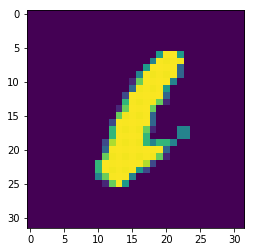

1 6


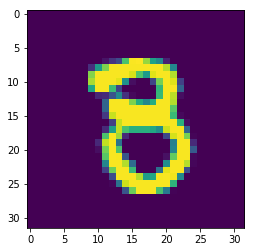

3 8


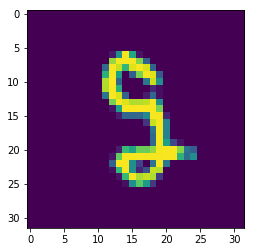

9 8


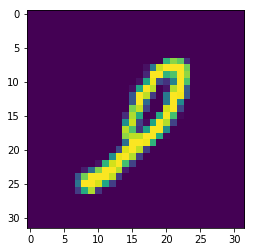

9 8


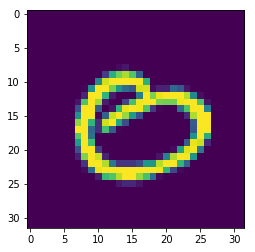

0 8


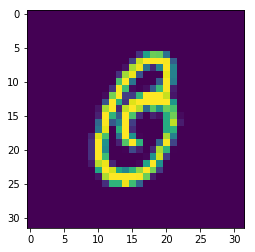

0 6


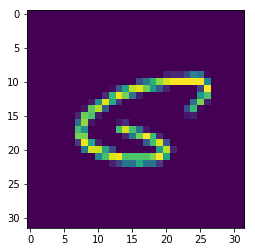

6 5


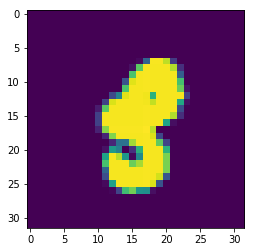

3 8


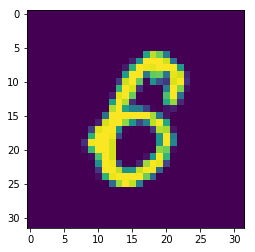

6 0


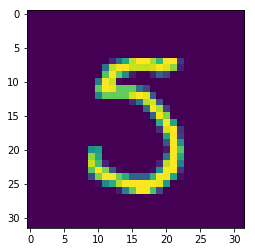

3 5


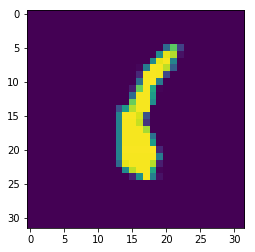

1 6


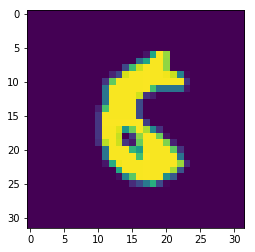

8 6


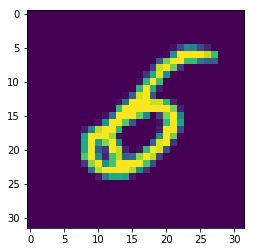

5 6


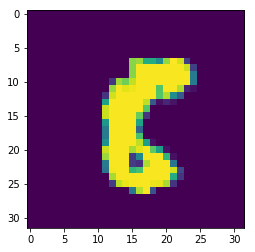

8 6


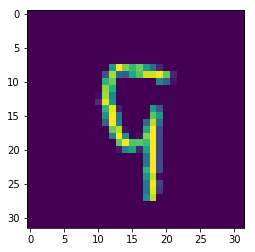

9 5


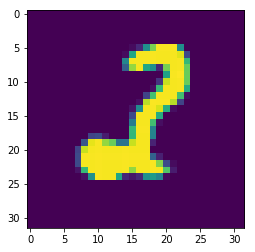

3 2


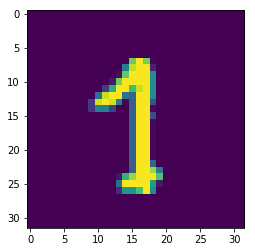

7 1


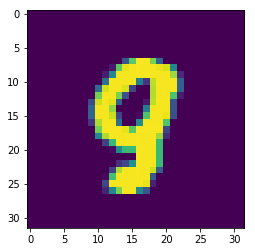

9 8


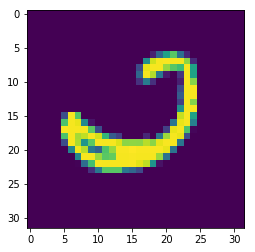

2 0


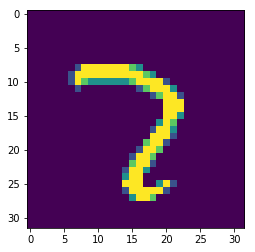

7 2


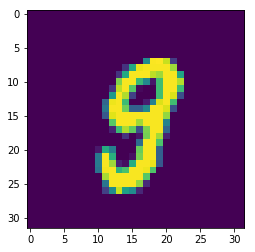

9 8


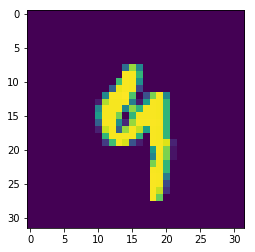

9 4


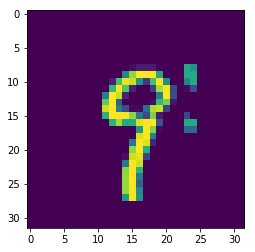

9 8


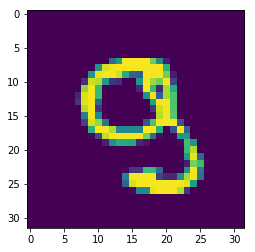

9 8


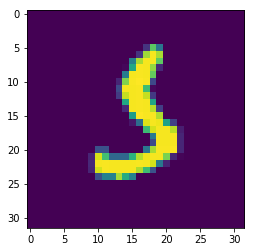

5 3


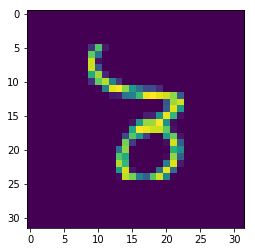

3 8


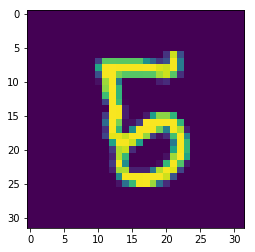

5 6


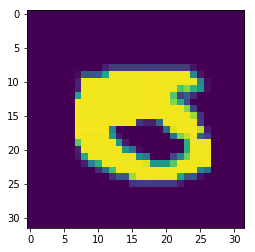

0 8


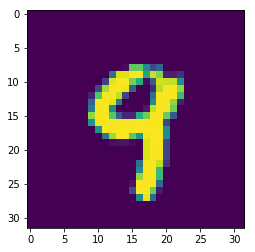

9 4


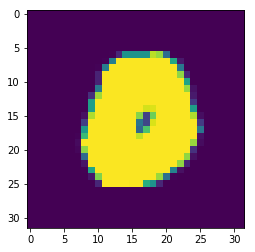

0 8


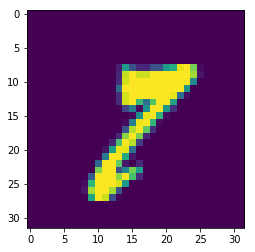

7 8


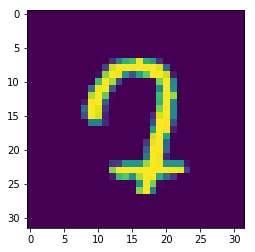

7 2


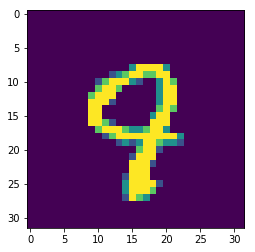

9 8


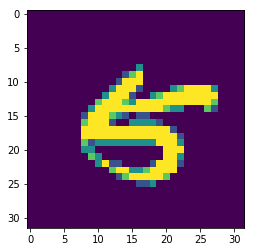

5 6


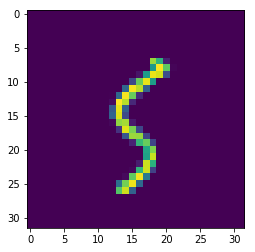

5 8


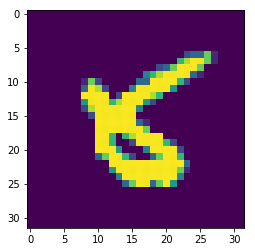

8 6


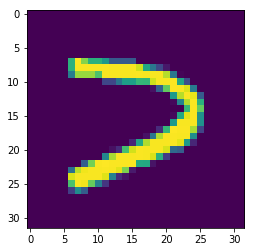

7 2


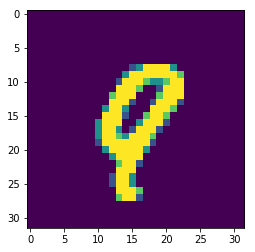

9 8


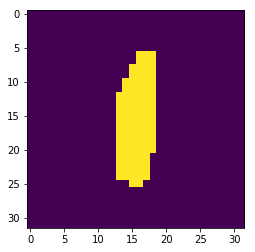

1 6


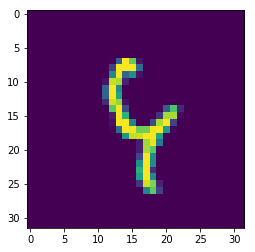

9 4


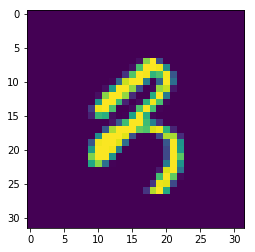

3 8


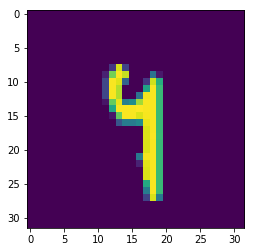

9 4


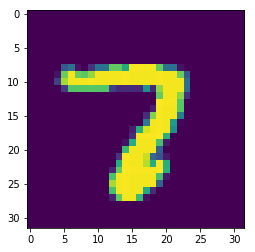

7 2


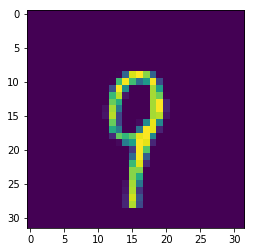

9 8


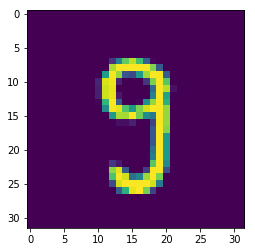

3 9


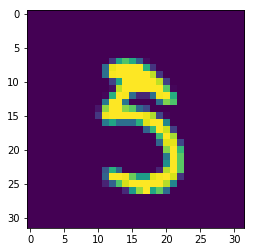

5 3


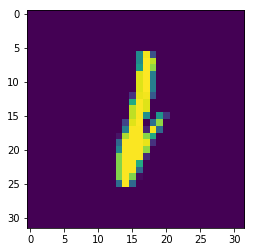

1 6


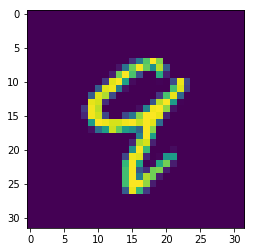

9 8


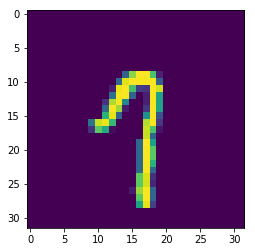

9 7


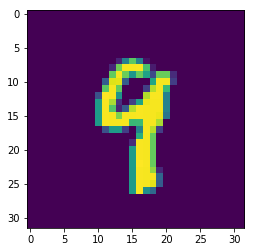

4 9


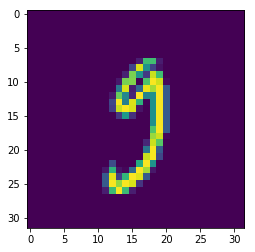

9 3


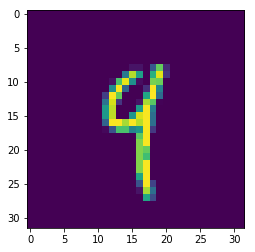

9 4


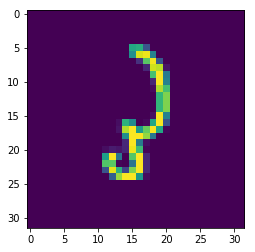

3 8


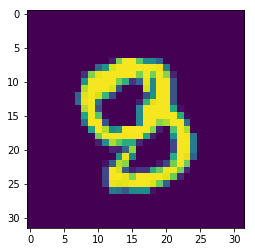

9 8


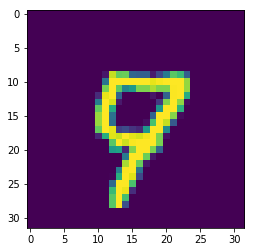

9 8


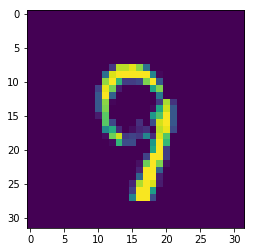

9 7


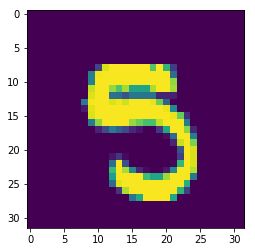

5 8


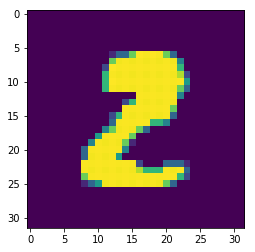

2 8


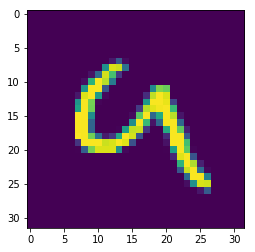

9 4


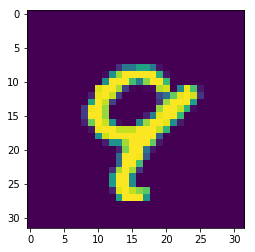

9 8


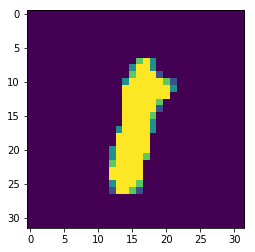

1 8


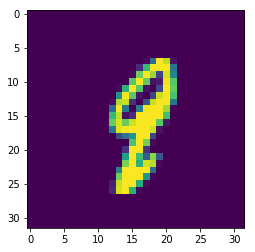

9 8


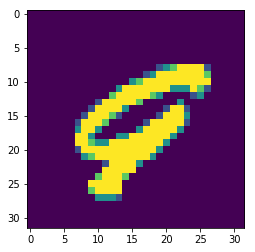

9 8


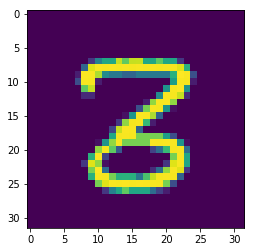

3 8


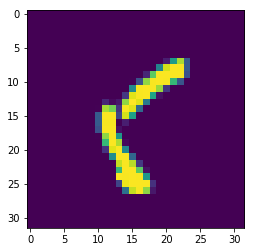

5 6


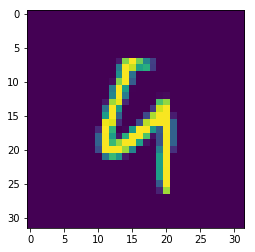

9 4


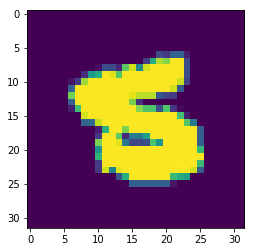

5 8


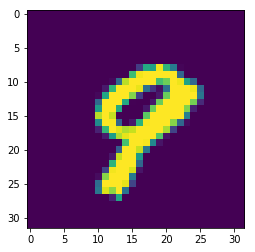

9 8


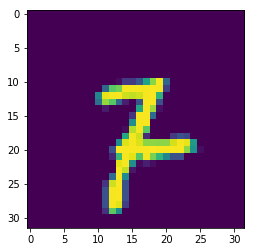

7 2


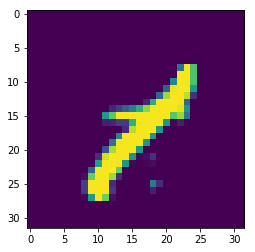

1 4


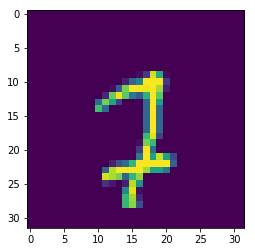

7 1


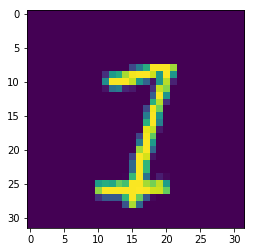

7 1


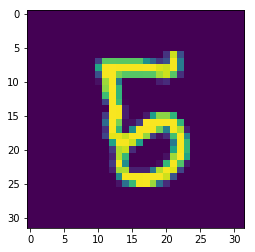

5 6


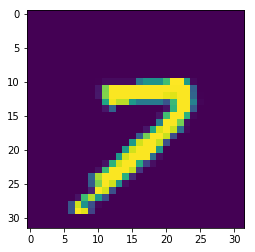

4 7


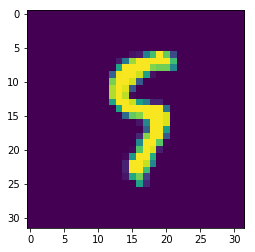

9 5


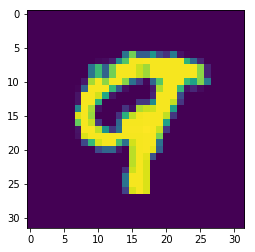

9 8


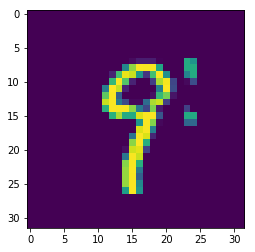

9 8


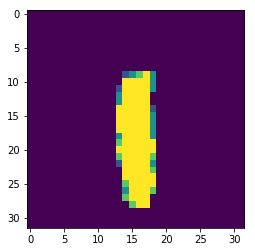

1 6


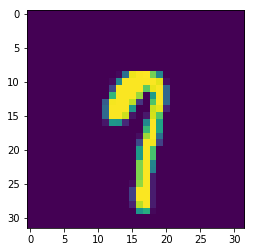

7 9


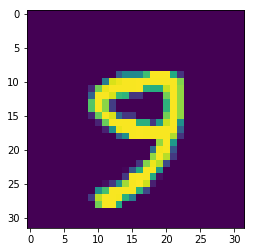

9 3


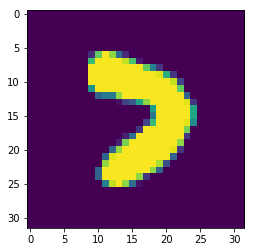

7 2


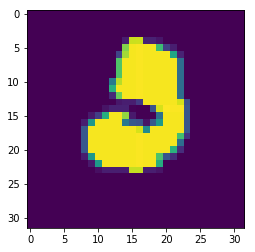

3 8


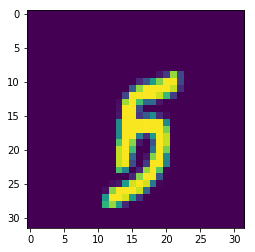

5 8


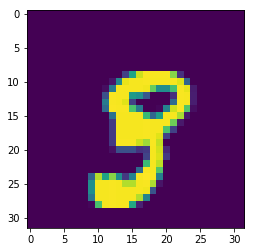

3 8


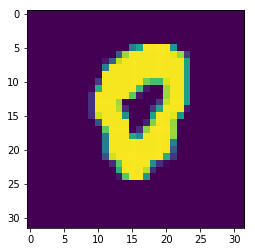

0 8


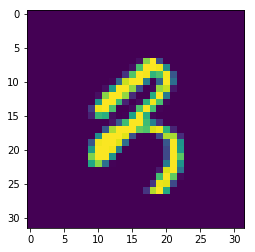

3 8


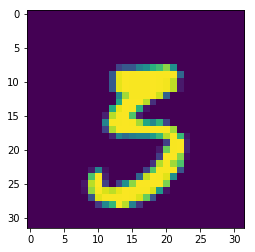

5 3


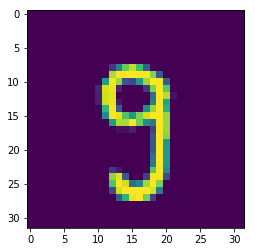

3 9


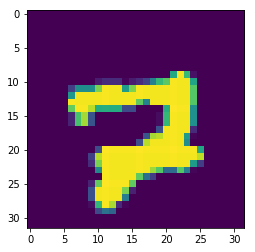

7 2


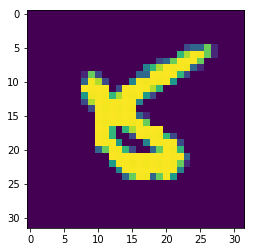

8 6


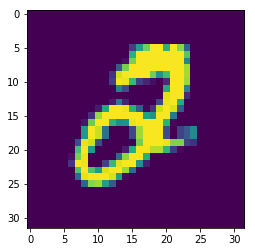

2 8


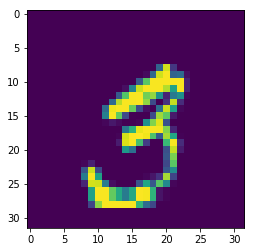

3 8


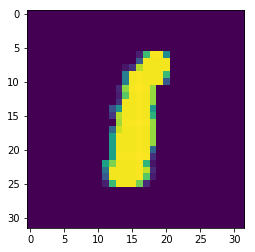

1 6


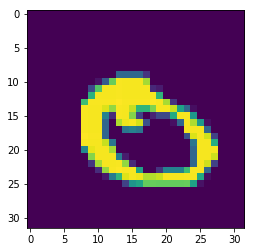

0 6


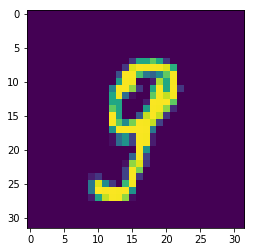

9 8


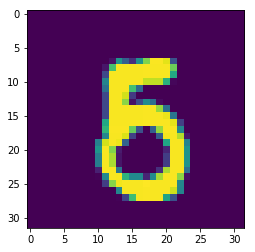

5 6


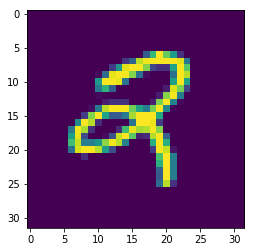

2 8


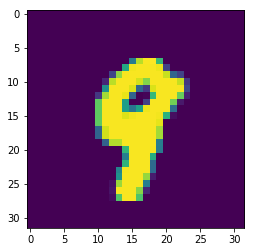

9 8


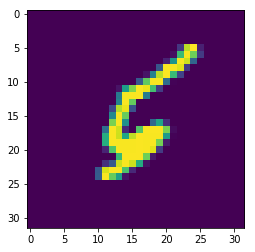

5 6


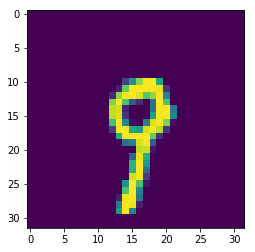

9 8


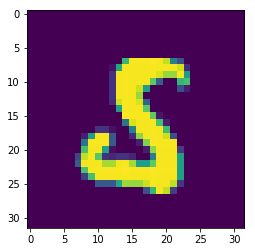

5 8


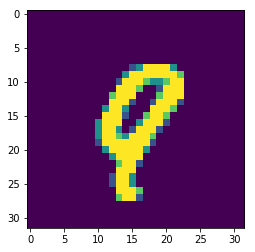

9 8


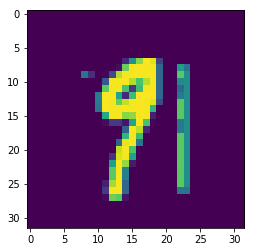

9 8


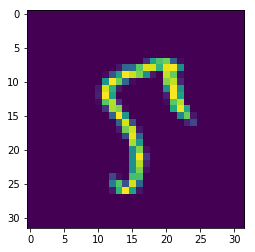

5 8


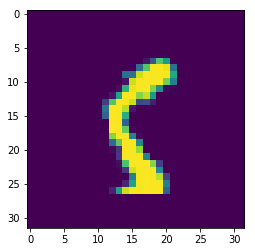

5 8


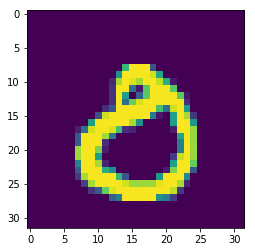

0 8


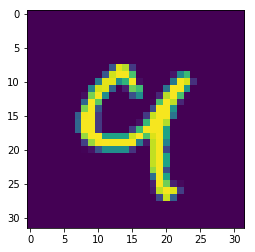

9 4


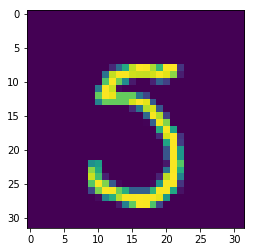

3 5


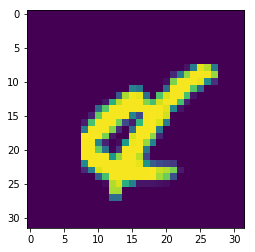

4 8


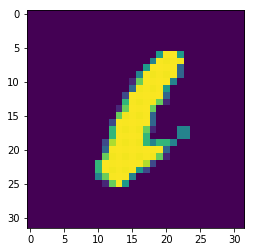

1 6


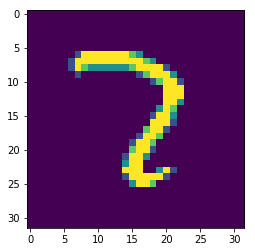

7 2


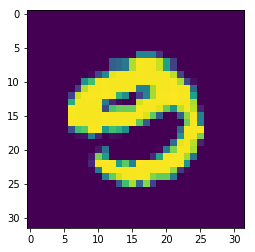

9 8


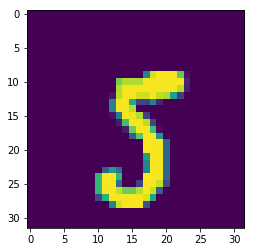

5 8


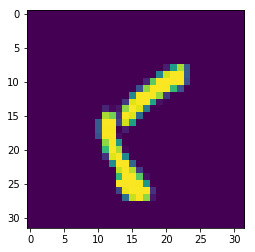

5 6


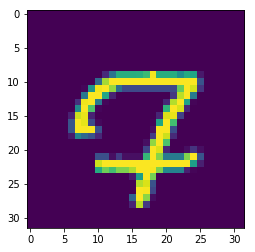

7 2


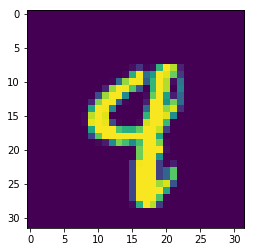

9 8


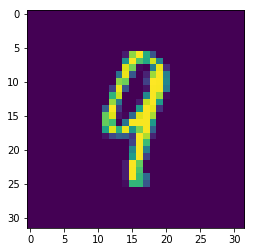

9 4


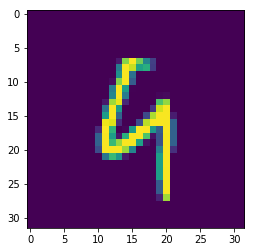

9 4


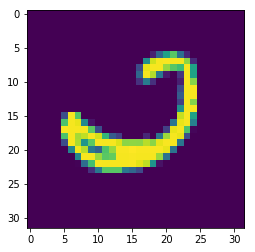

2 0


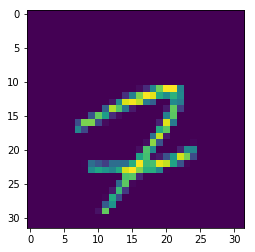

7 2


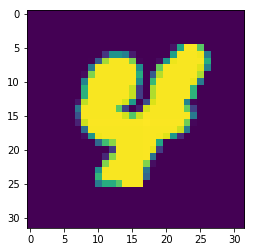

4 8


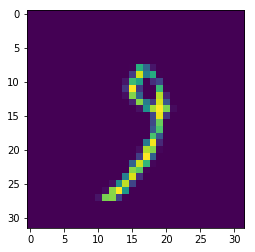

9 3


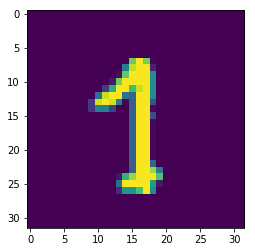

7 1


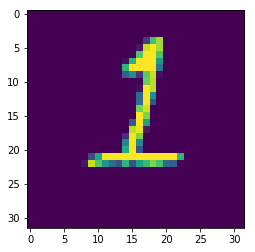

1 2


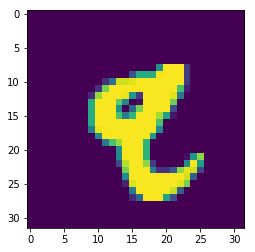

9 8


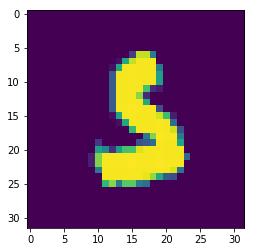

5 3


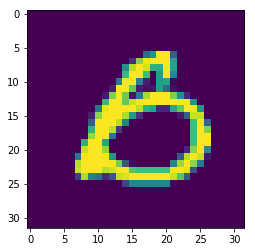

0 6


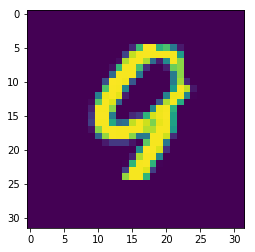

9 4


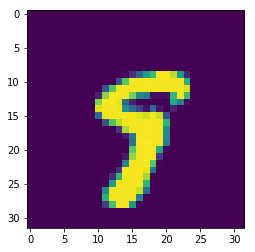

9 8


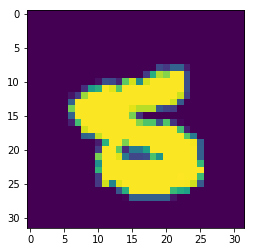

5 8


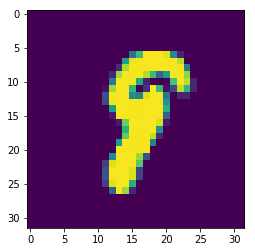

9 8


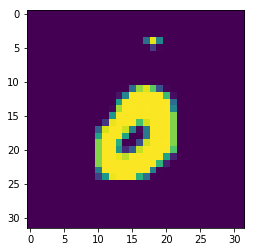

0 6


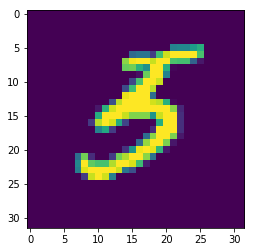

5 3


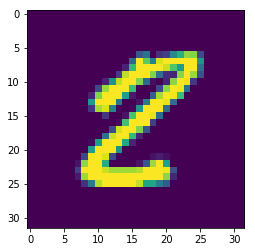

2 8


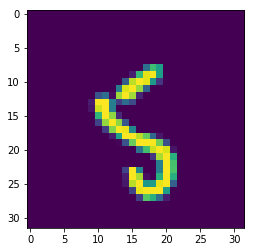

5 8


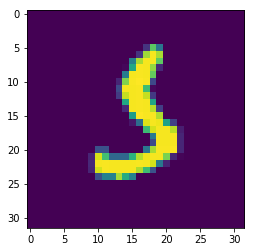

5 3


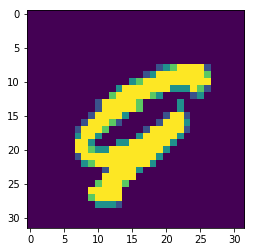

9 8


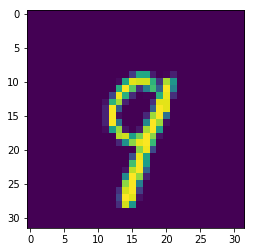

9 8


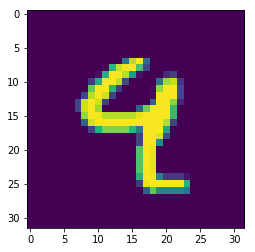

9 4


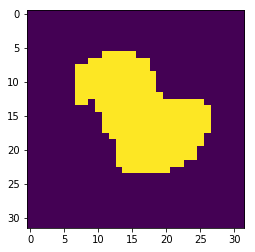

3 8


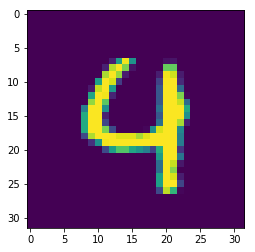

9 4


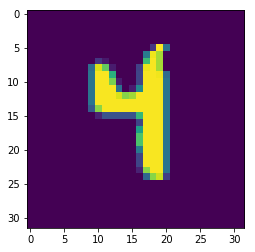

4 1


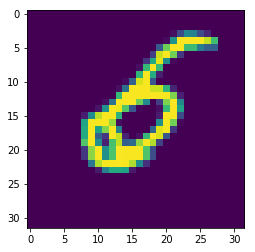

5 6


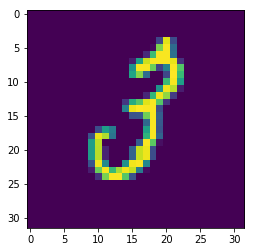

3 8


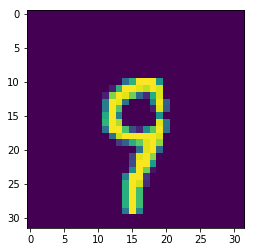

9 8


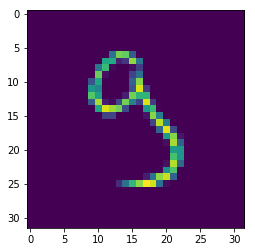

9 3


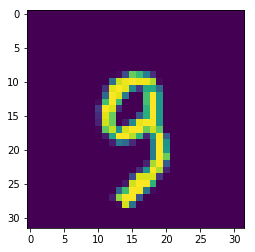

9 3


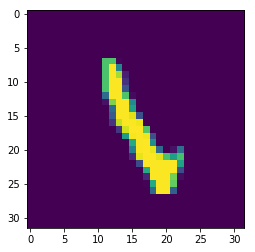

1 5


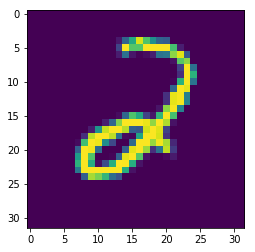

2 8


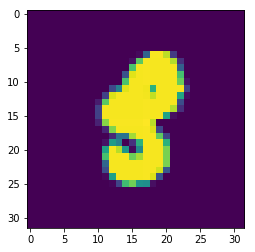

3 8


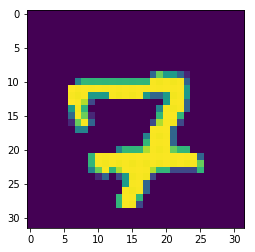

7 2


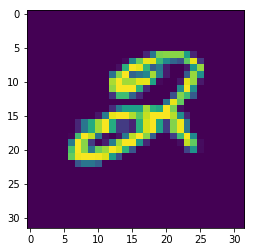

2 8


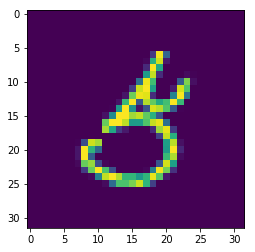

5 8


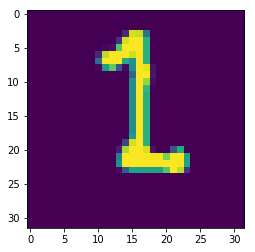

1 2


In [60]:
for i in unmatched:
    plt.imshow(X_train[i].reshape((32,32)))
    plt.show()
    print(Y_train[i].argmax(), check_data[i])

In [51]:
Y_test = cnn_model.predict(X_test)
pred = np.argmax(Y_test, axis = 1)

(<matplotlib.image.AxesImage at 0x11f7d13c8>, 2, 2)

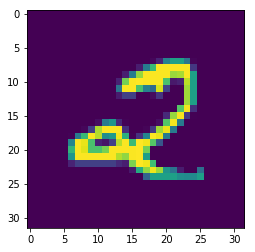

In [53]:
plt.imshow(X_test[25000].reshape((32,32))), pred[25000], Y_test[25000].argmax()

In [54]:
#output to submit file
submissions = pd.DataFrame({'ImageId': np.arange(1 , 1 + test.shape[0]), 'Label': pred.astype(int)})
submissions.to_csv('./keras(aug_data).csv', index=False)